## Notebook 6: Boosted Tree Classifier (XGBoost)

**Goal:**  
Train and tune an XGBoost classifier to predict customer conversion, leveraging its ability to handle nonlinearity, class imbalance, and feature interaction.

This notebook:
- Loads the train/test sets from Notebook 2
- Trains and tunes an XGBoost Classifier
- Evaluates the model with classification metrics and a confusion matrix
- Visualizes feature importances
- Saves the model for later comparison

### Imports and loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load training and testing data
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/y_test.p', 'rb') as f:
    y_test = pickle.load(f)

### Train and Tune XGBoost

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best XGBoost parameters:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:55:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### Evaluate Model Performance

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       178
           1       0.93      0.99      0.96      1300

    accuracy                           0.93      1478
   macro avg       0.92      0.72      0.78      1478
weighted avg       0.93      0.93      0.92      1478



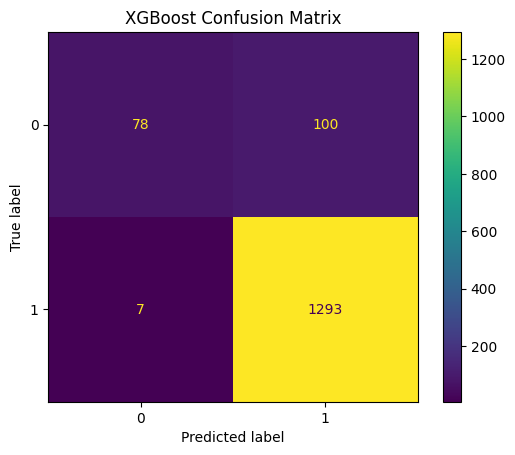

In [ ]:
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("XGBoost Confusion Matrix")
plt.show()

The XGBoost classifier outperformed previous models with exceptional accuracy and recall for Class 1 (converters), making it a strong candidate for deployment.

- Recall for Class 1 reached 100%, meaning no potential converters were missed.
- Precision remained high at 93%, and the model showed consistent performance across both classes.
- While recall for Class 0 improved over Ridge and Lasso (now 42%), there is still room for reducing false positives.

XGBoost balances interpretability and performance and is well-suited for complex datasets with feature interactions and nonlinear relationships.

### Visualize Feature Importances

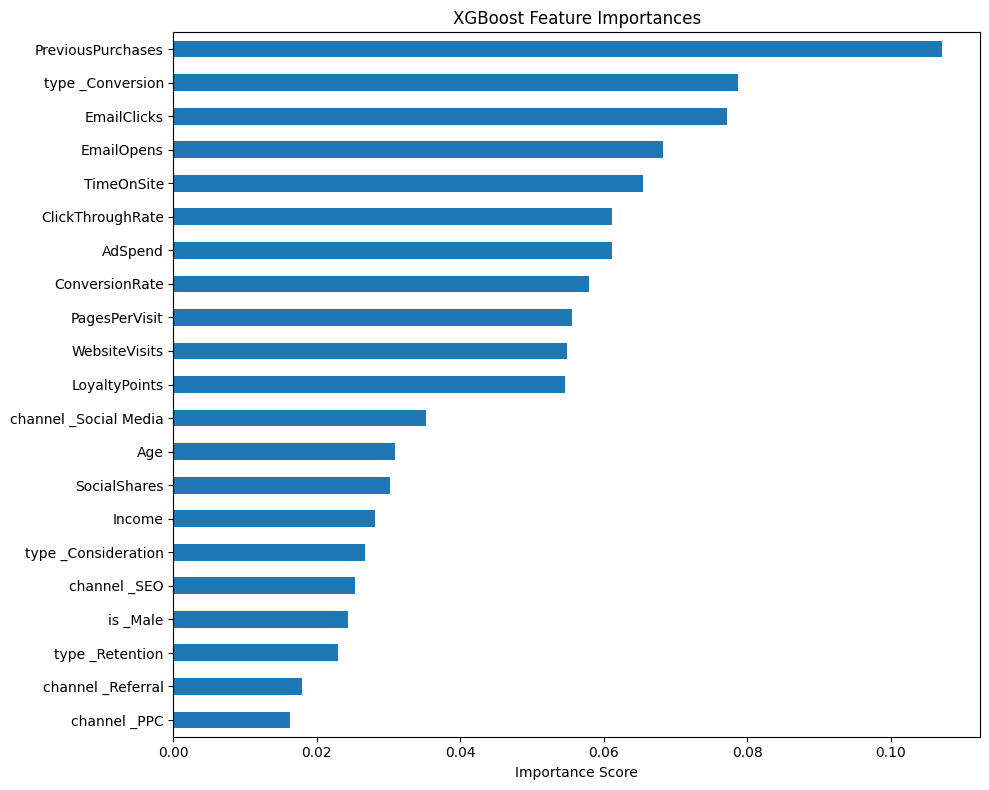

In [ ]:
importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 8))
importances.plot(kind='barh')
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

XGBoost emphasized behavioral history and campaign targeting as primary drivers of conversion:

- **PreviousPurchases** was the most important feature, confirming the power of retention-based marketing.
- Campaign type (**type_Conversion**) and email engagement (**EmailClicks**, **EmailOpens**) followed closely.
- Consistent with previous models, user interaction features like **TimeOnSite** and **PagesPerVisit** remained highly important.

Demographic and channel-related features were again found to be less impactful, suggesting that behavioral data provides more predictive power than static user attributes.

These insights can directly inform segmentation strategy, campaign design, and budget allocation.

### Save the trained model

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/MISY331/xgb_model.p', 'wb') as f:
    pickle.dump(best_xgb, f)